In [2]:
import os
import h5py
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

from scipy.stats import norm
from splotch.utils import savagedickey

In [29]:
### REPLACE with path to AnnData downloaded from GCP ###
data_dir = '/Users/adaly/Documents/mouse_colon/csplotch_anndata'
adata_betas = sc.read_h5ad(os.path.join(data_dir, 'adata_csplotch_celltype_betas.h5ad'))

### Fig4e, SFig8: regional variation in deconvolved cellular expression signals

In [4]:
def bf_to_stars(bf):
    if bf > 100:
        return '****'
    elif bf > 30:
        return '***'
    elif bf > 10:
        return '**'
    elif bf > 2:
        return '*'
    else:
        return 'ns'

In [18]:
# One row per gene, generate KDE plots showing the posterior Beta density for each gene in each colon region (for a given AAR + celltype + age)
def plot_regional_expression(genes, age, aar, celltype, xlim=None, ylim=None, genes_bold=None,
                             brkt_offset=0.1, brkt_ht=0.1):
    
    fig, ax = plt.subplots(len(genes), figsize=(5, len(genes)+1), constrained_layout=True)
        
    for i, g in enumerate(genes):
        # Plot KDE for gene beta each region
        for reg in ['Proximal', 'Middle', 'Distal']:
            cond = '%s BL6WT.%s' % (age, reg)
            
            inds = np.logical_and(adata_betas.obs.condition==cond, 
                                  adata_betas.obs.annotation==aar)
            inds = np.logical_and(adata_betas.obs.celltype==celltype,
                                  inds)
            mu = adata_betas[inds, g].X.squeeze()
            sigma = adata_betas[inds, g].layers['X_stds'].squeeze()
            
            d = np.random.normal(loc=mu, scale=sigma, size=1000)
            sns.kdeplot(d, label=reg, ax=ax[i], fill=False)

        # Mark significant regional changes
        y_hts = []

        for (reg1, reg2) in [('Proximal', 'Middle'),('Proximal', 'Distal'), ('Middle', 'Distal')]:
            inds = np.logical_and(adata_betas.obs.annotation==aar,
                                  adata_betas.obs.celltype==celltype)
            
            cond1 = '%s BL6WT.%s' % (age, reg1)
            inds1 = np.logical_and(adata_betas.obs.condition==cond1, inds)
            mu1 = adata_betas[inds1, g].X.squeeze()
            sigma1 = adata_betas[inds1, g].layers['X_stds'].squeeze()

            d1 = np.random.normal(loc=mu1, scale=sigma1, size=1000)

            cond2 = '%s BL6WT.%s' % (age, reg2)
            inds2 = np.logical_and(adata_betas.obs.condition==cond2, inds)
            mu2 = adata_betas[inds2, g].X.squeeze()
            sigma2 = adata_betas[inds2, g].layers['X_stds'].squeeze()

            d2 = np.random.normal(loc=mu2, scale=sigma2, size=1000)

            bf = savagedickey(d1, d2)
            if bf > 2:
                y1 = norm.pdf(mu1, loc=mu1, scale=sigma1)
                y2 = norm.pdf(mu2, loc=mu2, scale=sigma2)
                ymax = np.maximum(y1, y2) + brkt_offset 

                # Ensure a minimum spacing between horizontal lines between peaks
                if len(y_hts) > 0 and np.abs(np.min(ymax-np.array(y_hts))) < 8*brkt_ht:
                    ymax += 8*brkt_ht
                y_hts.append(ymax)

                ax[i].plot([d1.mean(), d1.mean(), d2.mean(), d2.mean()],
                           [ymax, ymax+brkt_ht, ymax+brkt_ht, ymax], c='k')
                ax[i].text((d1.mean()+d2.mean())/2, ymax+brkt_ht, bf_to_stars(bf), ha='center')

        ax[i].set_xlim(xlim)
        ax[i].set_ylim(ylim)
        ax[i].set_ylabel(r'$p(\beta)$')
        
        if genes_bold is not None and g in genes_bold:
            ax[i].set_title(g, fontweight='bold')
        else:
            ax[i].set_title(g)
        
        if i == len(genes)-1:
            ax[i].set_xlabel(r'$\beta$')
            ax[i].legend(bbox_to_anchor=(1,0), loc='lower left')
        elif xlim is not None:
            ax[i].set_xticks([])
    
    return fig, ax

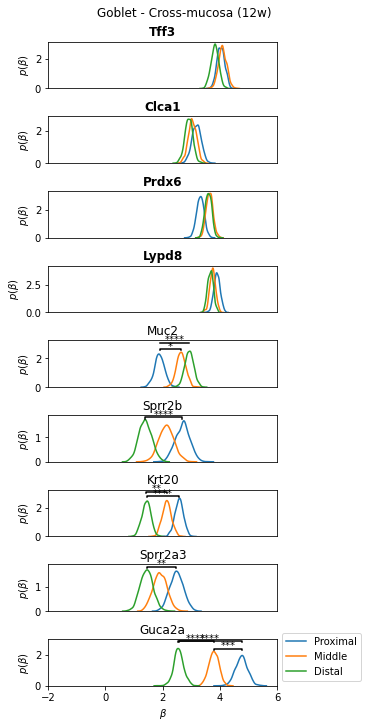

In [19]:
goblet_markers = ['Tff3', 'Clca1', 'Prdx6', 'Lypd8']
goblet_others = ['Muc2', 'Sprr2b', 'Krt20', 'Sprr2a3', 'Guca2a'] 
fig, ax = plot_regional_expression(goblet_markers+goblet_others, '12w', 'cross-mucosa', 'Goblet',
                                   genes_bold=goblet_markers,
                                   brkt_offset=0.05, brkt_ht=0.05, xlim=(-2,6),)
plt.suptitle('Goblet - Cross-mucosa (12w)')
plt.show()

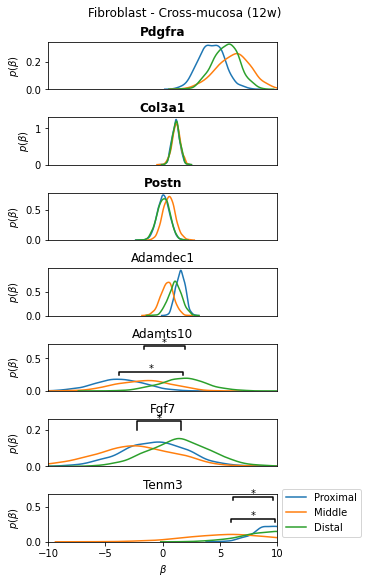

In [20]:
fibro_markers = ['Pdgfra', 'Col3a1', 'Postn']
fibro_others = ['Adamdec1', 'Adamts10', 'Fgf7', 'Tenm3'] 
fig, ax = plot_regional_expression(fibro_markers+fibro_others, '12w', 'cross-mucosa', 'Fibroblast',
                                   genes_bold=fibro_markers,
                                   brkt_offset=0.05, brkt_ht=0.05, xlim=(-10,10))
plt.suptitle('Fibroblast - Cross-mucosa (12w)')
plt.show()

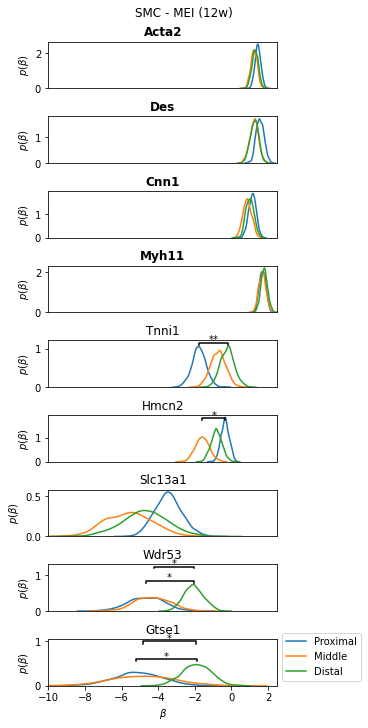

In [22]:
myo_markers = ['Acta2', 'Des', 'Cnn1', 'Myh11']
myo_others = ['Tnni1', 'Hmcn2', 'Slc13a1', 'Wdr53', 'Gtse1'] 
fig, ax = plot_regional_expression(myo_markers+myo_others, '12w', 'externa and interna', 'SMC',
                                   genes_bold=myo_markers,
                                   brkt_offset=0.05, brkt_ht=0.05, xlim=(-10,2.5))
plt.suptitle('SMC - MEI (12w)')
plt.show()

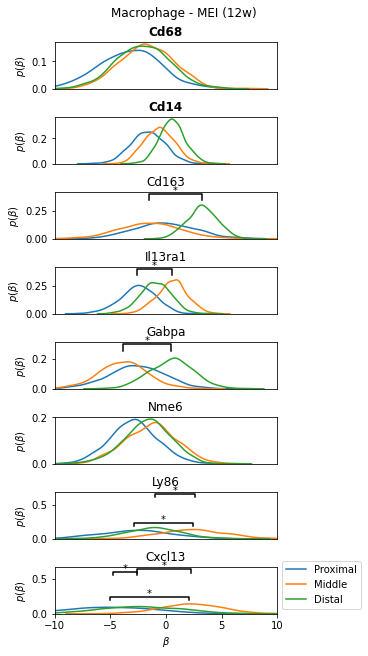

In [23]:
macro_markers = ['Cd68', 'Cd14']
macro_others = ['Cd163', 'Il13ra1', 'Gabpa', 'Nme6', 'Ly86', 'Cxcl13'] 
fig, ax = plot_regional_expression(macro_markers+macro_others, '12w', 'externa and interna', 'Macrophage',
                                   genes_bold=macro_markers,
                                   brkt_offset=0.05, brkt_ht=0.05, xlim=(-10,10))
plt.suptitle('Macrophage - MEI (12w)')
plt.show()

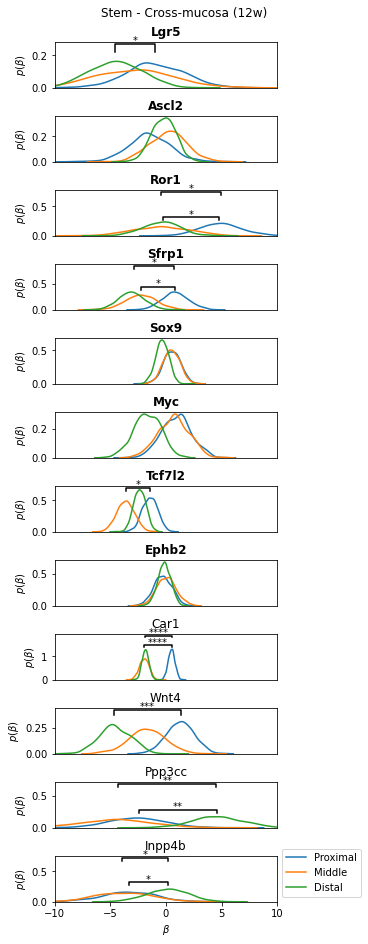

In [24]:
stem_markers = ['Lgr5', 'Ascl2', 'Ror1', 'Sfrp1', 'Sox9', 'Myc', 'Tcf7l2', 'Ephb2']
stem_others = ['Car1', 'Wnt4', 'Ppp3cc', 'Inpp4b'] 
fig, ax = plot_regional_expression(stem_markers+stem_others, '12w', 'cross-mucosa', 'Stem',
                                   genes_bold=stem_markers, xlim=(-10,10),
                                   brkt_offset=0.05, brkt_ht=0.05)
plt.suptitle('Stem - Cross-mucosa (12w)')
plt.show()

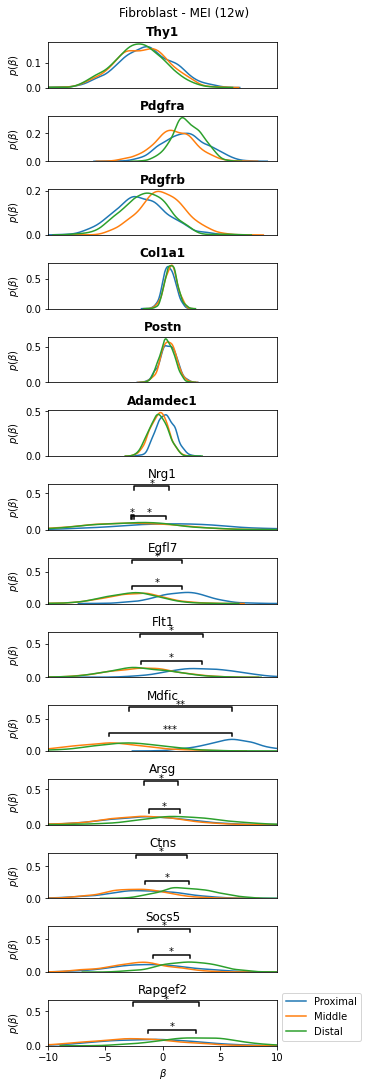

In [25]:
fibro_markers = ['Thy1', 'Pdgfra', 'Pdgfrb', 'Col1a1', 'Postn', 'Adamdec1']
fibro_others = ['Nrg1', 'Egfl7', 'Flt1', 'Mdfic', 'Arsg', 'Ctns', 'Socs5', 'Rapgef2'] 
fig, ax = plot_regional_expression(fibro_markers+fibro_others, '12w', 'externa and interna', 'Fibroblast',
                                   genes_bold=fibro_markers, xlim=(-10,10),
                                   brkt_offset=0.05, brkt_ht=0.05)
plt.suptitle('Fibroblast - MEI (12w)')
plt.show()

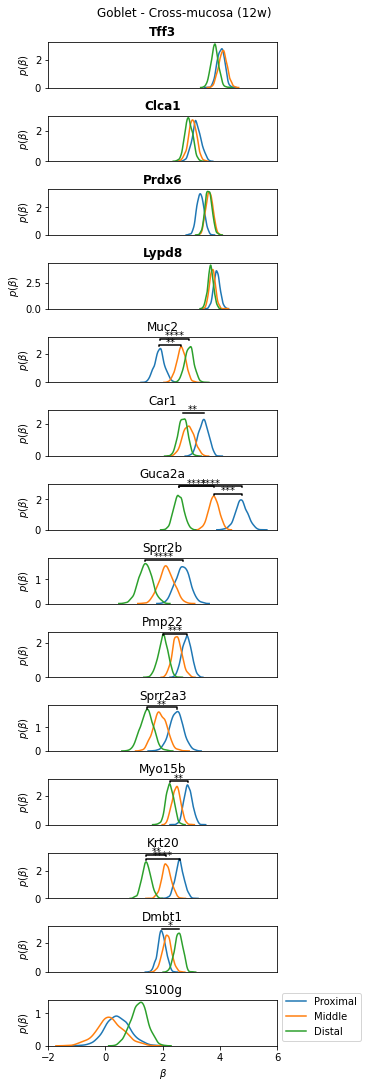

In [28]:
goblet_markers = ['Tff3', 'Clca1', 'Prdx6', 'Lypd8']
goblet_others = ['Muc2', 'Car1', 'Guca2a', 'Sprr2b', 'Pmp22', 'Sprr2a3', 'Myo15b', 'Krt20', 'Dmbt1', 'S100g']
fig, ax = plot_regional_expression(goblet_markers+goblet_others, '12w', 'cross-mucosa', 'Goblet',
                                   genes_bold=goblet_markers,
                                   brkt_offset=0.05, brkt_ht=0.05, xlim=(-2,6),)
plt.suptitle('Goblet - Cross-mucosa (12w)')
plt.show()